In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import ViTMAEForPreTraining
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformation
img_size = 224
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load CIFAR-10 and create known/unknown splits.
# In this example, classes 0-4 are considered "seen" and 5-9 are "unseen".
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
known_classes = [0, 1, 2, 3, 4]   # seen classes
unknown_classes = [5, 6, 7, 8, 9]  # unseen classes

known_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in known_classes]
unknown_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in unknown_classes]
known_data = Subset(train_dataset_full, known_idxs)
unknown_data = Subset(train_dataset_full, unknown_idxs)

train_loader = DataLoader(known_data, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(unknown_data, batch_size=16, shuffle=False)

# -------------------------------
# Build a classifier based on the pre-trained MAE encoder
# -------------------------------
class ViTMAEClassifier(nn.Module):
    def __init__(self, mae_model, num_classes, freeze_encoder=False):
        super(ViTMAEClassifier, self).__init__()
        # Use the full base model so that input images are processed correctly (patch embedding, etc.)
        self.encoder = mae_model.base_model  
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        hidden_size = mae_model.config.hidden_size  # token embedding size (e.g. 768)

        # Classification head: maps the [CLS] token representation to the known classes.
        self.cls_head = nn.Linear(hidden_size, num_classes)

        # Auxiliary reconstruction head for anomaly detection.
        # This branch tries to reconstruct the [CLS] token.
        self.rec_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        # x: input image tensor, shape [B, 3, H, W]
        # Pass through the full base model that includes patch embedding.
        enc_out = self.encoder(x).last_hidden_state  # shape: [B, num_tokens, hidden_size]
        # Use the first token ([CLS] token) as the global image representation.
        cls_token = enc_out[:, 0]  # shape: [B, hidden_size]
        logits = self.cls_head(cls_token)
        rec_output = self.rec_head(cls_token)  # Auxiliary reconstruction branch.
        return logits, rec_output, cls_token

# Load the pre-trained MAE model.
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

# Build our classifier with 5 seen classes.
num_seen_classes = len(known_classes)  # 5 in this example
model = ViTMAEClassifier(mae_model, num_seen_classes, freeze_encoder=False).to(device)

# Define loss functions and optimizer.
classification_loss_fn = nn.CrossEntropyLoss()
reconstruction_loss_fn = nn.MSELoss()  # reconstruction error on the [CLS] token.
optimizer = optim.Adam(model.parameters(), lr=1e-4)

'''
# -------------------------------
# Training loop (fine-tuning on seen classes)
# -------------------------------
num_epochs = 5
training_log = {"epochs": []}
for epoch in range(num_epochs):
    model.train()
    running_class_loss = 0.0
    running_rec_loss = 0.0
    correct, total = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        logits, rec_output, cls_token = model(images)
        # Classification loss (cross entropy)
        class_loss = classification_loss_fn(logits, labels)
        # Reconstruction loss on [CLS] token
        rec_loss = reconstruction_loss_fn(rec_output, cls_token.detach())
        # Weighted sum of losses
        loss = class_loss + 0.5 * rec_loss
        loss.backward()
        optimizer.step()

        running_class_loss += class_loss.item()
        running_rec_loss += rec_loss.item()
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        progress_bar.set_postfix(class_loss=f"{class_loss.item():.4f}",
                                 rec_loss=f"{rec_loss.item():.4f}",
                                 acc=f"{(100*correct/total):.2f}%")
        
    epoch_log = {
        "epoch": epoch+1,
        "avg_class_loss": running_class_loss/len(train_loader),
        "avg_rec_loss": running_rec_loss/len(train_loader),
        "train_acc": 100*correct/total
    }
    training_log["epochs"].append(epoch_log)
    print(f"Epoch {epoch+1} - Train Accuracy: {100*correct/total:.2f}%")
    
# Save training log and model weights.
os.makedirs("./mae_finetune_outputs", exist_ok=True)
with open("./mae_finetune_outputs/training_log.json", "w") as f:
    json.dump(training_log, f, indent=4)
torch.save(model.state_dict(), "./mae_finetune_outputs/mae_classifier.pth")

# -------------------------------
# Inference: Combining Classification and Anomaly Score
# -------------------------------
model.eval()
anomaly_threshold = 0.1  # Adjust this threshold using a validation set
results = []
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        logits, rec_output, cls_token = model(images)
        # Compute classification probabilities
        probs = torch.softmax(logits, dim=1)
        # Compute anomaly (reconstruction) error on the [CLS] token.
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1)  # one error per image
        
        # Decide seen vs. unseen: if the reconstruction error is higher than the threshold, mark as unseen.
        for i in range(images.size(0)):
            if rec_error[i] > anomaly_threshold:
                pred = "unseen"
            else:
                pred_class = probs[i].argmax().item()
                pred = f"seen_class_{pred_class}"
            results.append(pred)

print("Inference results on validation (unknown) set:")
print(results)
'''

2025-04-13 02:32:24.435231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744511544.857414      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744511544.975997      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


100%|██████████| 170M/170M [00:01<00:00, 86.6MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

'\n# -------------------------------\n# Training loop (fine-tuning on seen classes)\n# -------------------------------\nnum_epochs = 5\ntraining_log = {"epochs": []}\nfor epoch in range(num_epochs):\n    model.train()\n    running_class_loss = 0.0\n    running_rec_loss = 0.0\n    correct, total = 0, 0\n    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")\n    for images, labels in progress_bar:\n        images = images.to(device)\n        labels = labels.to(device)\n        optimizer.zero_grad()\n\n        logits, rec_output, cls_token = model(images)\n        # Classification loss (cross entropy)\n        class_loss = classification_loss_fn(logits, labels)\n        # Reconstruction loss on [CLS] token\n        rec_loss = reconstruction_loss_fn(rec_output, cls_token.detach())\n        # Weighted sum of losses\n        loss = class_loss + 0.5 * rec_loss\n        loss.backward()\n        optimizer.step()\n\n        running_class_loss += class_loss.item()\n        r

In [3]:
import torch

# Recreate the model architecture exactly as it was during training.
model = ViTMAEClassifier(mae_model, num_seen_classes, freeze_encoder=False).to(device)

# Load the state dictionary from the .pth file.
state_dict = torch.load("/kaggle/input/mae_seen_unseen_classifier_5ep/pytorch/5-epoch/1/mae_classifier_5epoch.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()  # Set the model to evaluation mode.


/tmp/ipykernel_31/2576384359.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/mae_seen_unseen_classifier_5ep/pytorch/5-epoch/1/mae_

ViTMAEClassifier(
  (encoder): ViTMAEModel(
    (embeddings): ViTMAEEmbeddings(
      (patch_embeddings): ViTMAEPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
    )
    (encoder): ViTMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTMAELayer(
          (attention): ViTMAEAttention(
            (attention): ViTMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivat

In [8]:
# During training:
train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
known_classes = [0, 1, 2, 3, 4]
unknown_classes = [5, 6, 7, 8, 9]

known_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in known_classes]
unknown_idxs = [i for i, (_, label) in enumerate(train_dataset_full) if label in unknown_classes]
known_data = Subset(train_dataset_full, known_idxs)
unknown_data = Subset(train_dataset_full, unknown_idxs)

train_loader = DataLoader(known_data, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(unknown_data, batch_size=16, shuffle=False)


Files already downloaded and verified


In [9]:
from torch.utils.data import ConcatDataset, DataLoader

# Create labels for calibration:
# For known_data samples, we'll assign label 0 ("seen")
# For unknown_data samples, assign label 1 ("unseen")
# Note: You can store these separately or wrap your subsets with a custom dataset that returns these labels.
class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, label):
        self.dataset = dataset  # the original dataset
        self.label = label      # integer: 0 for seen, 1 for unseen
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # ignore original CIFAR-10 label
        return img, self.label

# Wrap known_data and unknown_data with our custom labeled dataset
labeled_known = LabeledDataset(known_data, 0)
labeled_unknown = LabeledDataset(unknown_data, 1)

# Optionally, if you want to balance the calibration set, you might take a subset.
# For simplicity here, we merge them directly.
calibration_dataset = ConcatDataset([labeled_known, labeled_unknown])
calibration_loader = DataLoader(calibration_dataset, batch_size=16, shuffle=False)


In [10]:
import numpy as np
model.eval()
all_rec_errors = []
all_ground_truth = []  # 0: seen, 1: unseen

with torch.no_grad():
    for images, gt in calibration_loader:
        images = images.to(device)
        logits, rec_output, cls_token = model(images)
        # Compute error (mean squared error) per sample
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1).cpu().numpy()
        all_rec_errors.extend(rec_error)
        all_ground_truth.extend(gt.numpy())

all_rec_errors = np.array(all_rec_errors)
all_ground_truth = np.array(all_ground_truth)


In [11]:
thresholds = np.linspace(all_rec_errors.min(), all_rec_errors.max(), 50)  # 50 candidate thresholds
accuracy_per_thresh = []

for t in thresholds:
    # Mark as unseen (1) if error > threshold, else seen (0)
    preds = (all_rec_errors > t).astype(int)
    accuracy = (preds == all_ground_truth).mean()
    accuracy_per_thresh.append(accuracy)

best_threshold_idx = np.argmax(accuracy_per_thresh)
best_threshold_acc = thresholds[best_threshold_idx]
best_acc = accuracy_per_thresh[best_threshold_idx]

print(f"Best threshold (accuracy) = {best_threshold_acc:.4f} with accuracy = {best_acc:.4f}")z


Best threshold (accuracy) = 0.0026 with accuracy = 0.6543


In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(all_ground_truth, all_rec_errors)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
best_threshold_roc = roc_thresholds[optimal_idx]

print(f"ROC AUC = {roc_auc:.4f}")
print(f"Optimal threshold by max(TPR - FPR) = {best_threshold_roc:.4f}")


ROC AUC = 0.7076
Optimal threshold by max(TPR - FPR) = 0.0025


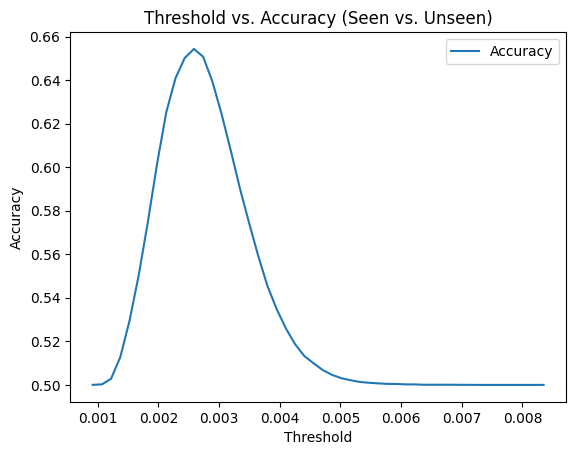

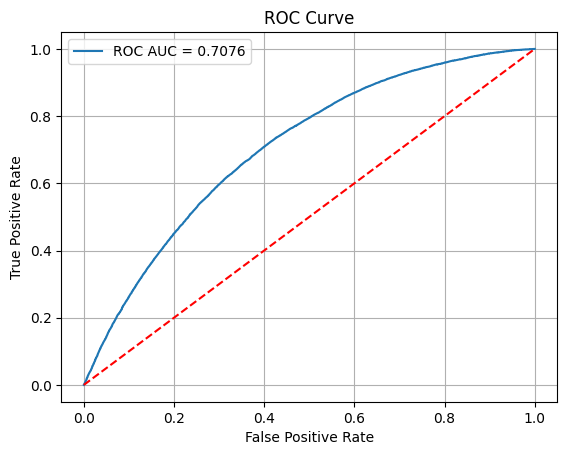

In [14]:
import matplotlib.pyplot as plt

plt.plot(thresholds, accuracy_per_thresh, label='Accuracy')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Threshold vs. Accuracy (Seen vs. Unseen)")
plt.legend()
plt.show()

plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from sklearn.metrics import f1_score

f1_per_thresh = []
for t in thresholds:
    preds = (all_rec_errors > t).astype(int)
    f1 = f1_score(all_ground_truth, preds)
    f1_per_thresh.append(f1)

best_threshold_idx = np.argmax(f1_per_thresh)
best_threshold_f1 = thresholds[best_threshold_idx]
best_f1 = f1_per_thresh[best_threshold_idx]

print(f"Best threshold (F1) = {best_threshold_f1:.4f} with F1 score = {best_f1:.4f}")


Best threshold (F1) = 0.0021 with F1 score = 0.7054


Confusion Matrix:
[[ 8793 16207]
 [ 2647 22353]]
Classification Report:
              precision    recall  f1-score   support

        seen       0.77      0.35      0.48     25000
      unseen       0.58      0.89      0.70     25000

    accuracy                           0.62     50000
   macro avg       0.67      0.62      0.59     50000
weighted avg       0.67      0.62      0.59     50000



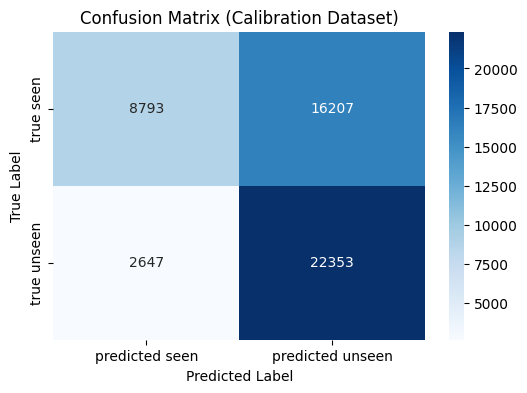

In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assume anomaly_threshold is set based on your calibration (e.g., best_threshold_f1)
anomaly_threshold = best_threshold_f1  # from your threshold tuning

# Use the calibration_loader that combines seen (label 0) and unseen (label 1) data.
model.eval()
all_preds = []    # To store predicted labels (as integers: 0 for seen, 1 for unseen)
all_targets = []  # To store the true labels (0 for seen, 1 for unseen)

with torch.no_grad():
    for images, labels in calibration_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        logits, rec_output, cls_token = model(images)
        probs = torch.softmax(logits, dim=1)
        
        # Compute reconstruction error per sample (MSE on [CLS] token)
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1)
        
        # For calibration we decide based solely on reconstruction error:
        # If error > anomaly_threshold, we predict unseen (label 1),
        # else we predict seen (label 0).
        preds = (rec_error > anomaly_threshold).int()  # tensor containing 0's and 1's
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

# Compute confusion matrix.
# Here, label 0 corresponds to "seen" and label 1 corresponds to "unseen".
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1])
print("Confusion Matrix:")
print(cm)

# Print a classification report.
report = classification_report(all_targets, all_preds, target_names=["seen", "unseen"])
print("Classification Report:")
print(report)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["predicted seen", "predicted unseen"],
            yticklabels=["true seen", "true unseen"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Calibration Dataset)")
plt.show()


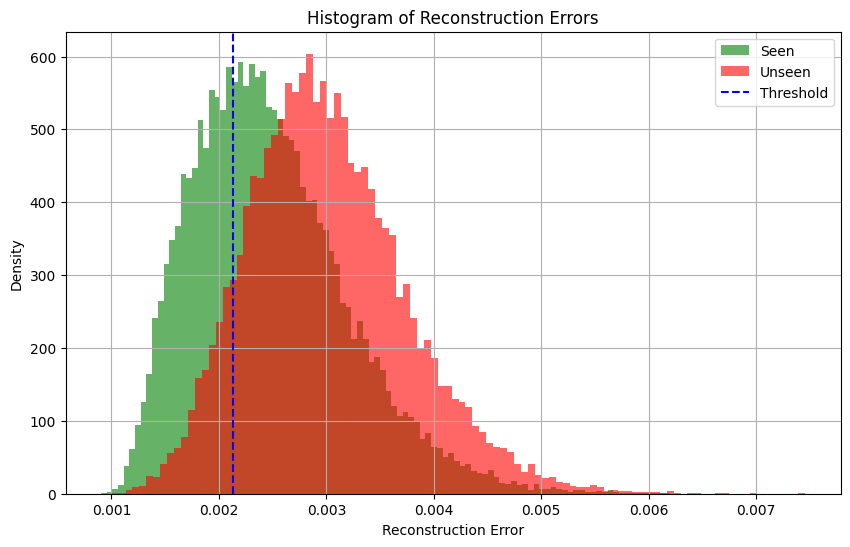

In [19]:
import torch
import matplotlib.pyplot as plt

rec_errors_seen = []
rec_errors_unseen = []

model.eval()
with torch.no_grad():
    # Seen (label 0 in your calibration set)
    for images, label in calibration_loader:
        images = images.to(device)
        label = label.to(device)
        
        logits, rec_output, cls_token = model(images)
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1).cpu().numpy()
        
        for i in range(len(label)):
            if label[i] == 0:
                rec_errors_seen.append(rec_error[i])
            else:
                rec_errors_unseen.append(rec_error[i])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(rec_errors_seen, bins=100, alpha=0.6, label='Seen', color='green', density=True)
plt.hist(rec_errors_unseen, bins=100, alpha=0.6, label='Unseen', color='red', density=True)
plt.axvline(x=anomaly_threshold, color='blue', linestyle='--', label='Threshold')
plt.title("Histogram of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


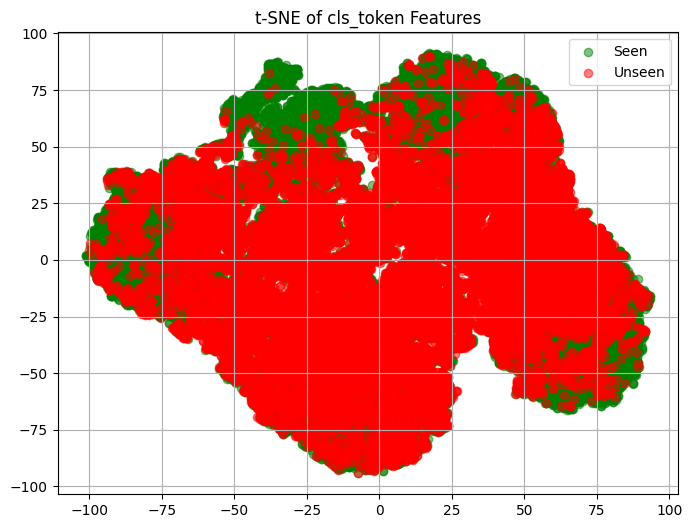

In [20]:
from sklearn.manifold import TSNE
import numpy as np

features = []
labels = []

model.eval()
with torch.no_grad():
    for images, label in calibration_loader:
        images = images.to(device)
        logits, rec_output, cls_token = model(images)
        features.append(cls_token.cpu().numpy())
        labels.extend(label.cpu().numpy())

features = np.vstack(features)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[labels==0, 0], features_2d[labels==0, 1], label='Seen', alpha=0.5, c='green')
plt.scatter(features_2d[labels==1, 0], features_2d[labels==1, 1], label='Unseen', alpha=0.5, c='red')
plt.title("t-SNE of cls_token Features")
plt.legend()
plt.grid(True)
plt.show()


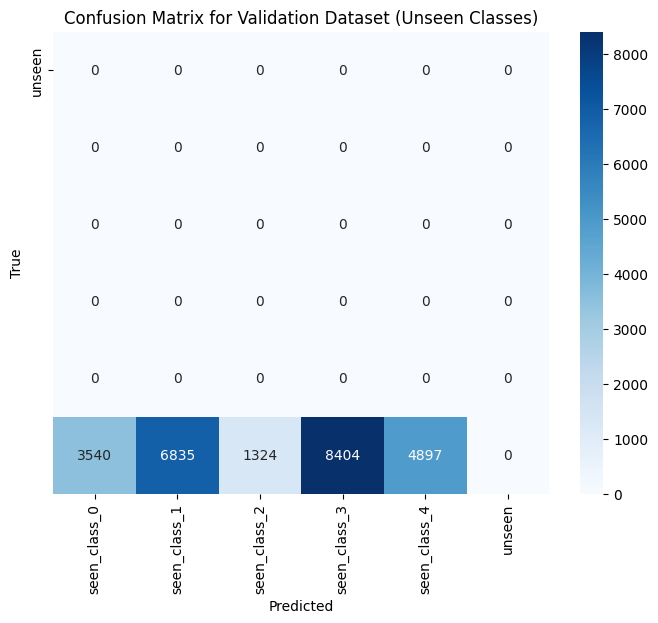

In [21]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming model, val_loader, and device are already defined
model.eval()
anomaly_threshold = 0.2  # Threshold for anomaly detection (adjust as needed)
results = []  # Store predicted labels
true_labels = []  # Store true labels

# Step 1: Run the Model on the Validation Dataset
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass through the model
        logits, rec_output, cls_token = model(images)
        
        # Compute classification probabilities for seen classes
        probs = torch.softmax(logits, dim=1)
        
        # Compute reconstruction error for anomaly detection
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1)  # Error per image
        
        # Classify each sample
        for i in range(images.size(0)):
            if rec_error[i] > anomaly_threshold:
                pred = "unseen"  # High error indicates an unseen class
            else:
                pred_class = probs[i].argmax().item()  # Highest prob seen class
                pred = f"seen_class_{pred_class}"
            results.append(pred)
            true_labels.append("unseen")  # All validation samples are unseen

# Step 2: Prepare Labels for the Confusion Matrix
# Define all possible class names (5 seen classes + 1 unseen)
class_names = [f"seen_class_{i}" for i in range(5)] + ["unseen"]

# Convert predictions to indices
pred_indices = []
for pred in results:
    if pred == "unseen":
        pred_indices.append(5)  # Index 5 for "unseen"
    else:
        class_id = int(pred.split('_')[-1])  # Extract number from "seen_class_X"
        pred_indices.append(class_id)

# All true labels are "unseen" (index 5)
true_indices = [5] * len(true_labels)

# Step 3: Generate and Visualize the Confusion Matrix
# Compute the confusion matrix
cm = confusion_matrix(true_indices, pred_indices, labels=range(6))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=["unseen"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Validation Dataset (Unseen Classes)')
plt.show()

In [11]:
torch.save(model.state_dict(), "./mae_finetune_outputs/mae_classifier_5epoch.pth")


In [12]:
with open("./mae_finetune_outputs/inference_results.json", "w") as f:
    json.dump(results, f, indent=4)


In [13]:
model_info = {
    "model_name": "ViT-MAE Classifier",
    "base_model": "facebook/vit-mae-base",
    "num_seen_classes": num_seen_classes,
    "seen_class_ids": known_classes,
    "unseen_class_ids": unknown_classes,
    "image_size": img_size,
    "threshold": anomaly_threshold,
    "epochs": num_epochs,
    "loss_fn": {
        "classification": "CrossEntropyLoss",
        "reconstruction": "MSELoss"
    }
}

with open("./mae_finetune_outputs/model_metadata.json", "w") as f:
    json.dump(model_info, f, indent=4)


In [16]:
with open("./mae_finetune_outputs/README.md", "w") as f:
    f.write("# ViT-MAE Classifier\n")
    f.write("This model classifies CIFAR-10 images into 5 known classes and detects unknowns using reconstruction loss.\n\n")
    f.write("## How it works\n")
    f.write("- Uses pretrained `facebook/vit-mae-base`\n")
    f.write("- Fine-tuned on CIFAR-10 classes 0-4\n")
    f.write("- Detects classes 5-9 as 'unseen' using a CLS reconstruction error threshold.\n")
    f.write(f"- Anomaly threshold used: `{anomaly_threshold}`\n\n")
    f.write("## Files\n")
    f.write("- `mae_classifier.pth`: trained weights\n")
    f.write("- `training_log.json`: training stats\n")
    f.write("- `inference_results.json`: inference predictions\n")
    f.write("- `model_metadata.json`: config and hyperparameters\n")


Saved reconstruction visualization to: mae_finetune_outputs/reconstruction_result.png


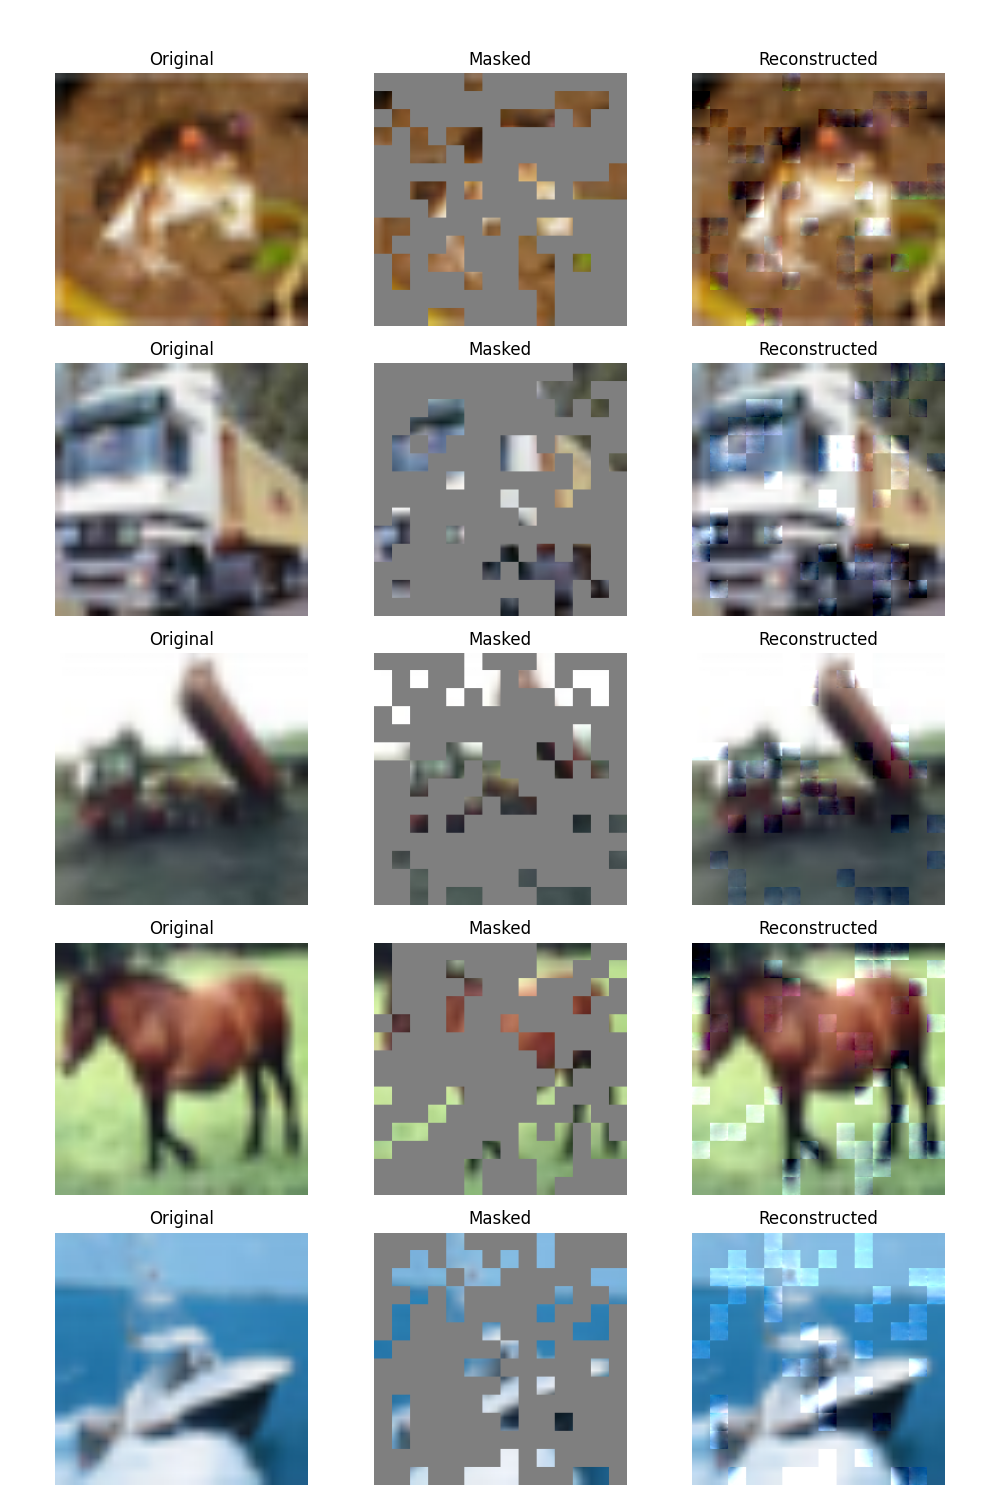

In [21]:
def patchify(img, patch_size):
    # img: (B, 3, H, W)
    B, C, H, W = img.shape
    assert H == W and H % patch_size == 0

    h = w = H // patch_size
    patches = img.reshape(B, C, h, patch_size, w, patch_size)
    patches = patches.permute(0, 2, 4, 3, 5, 1).reshape(B, h * w, patch_size * patch_size * C)
    return patches

def unpatchify(patches, patch_size, img_size):
    # patches: (B, N, patch_dim)
    B, N, patch_dim = patches.shape
    H = W = img_size
    h = w = H // patch_size
    assert N == h * w

    patches = patches.reshape(B, h, w, patch_size, patch_size, 3)
    patches = patches.permute(0, 5, 1, 3, 2, 4).reshape(B, 3, H, W)
    return patches

def visualize_and_save_reconstruction(mae_model, dataloader, save_path="mae_reconstruction.png", num_images=4):
    mae_model.eval()
    patch_size = mae_model.config.patch_size
    img_size = mae_model.config.image_size

    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    images_shown = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = mae_model(pixel_values=images, return_dict=True)
            recon_patches = outputs.logits  # shape: (B, N, patch_dim)
            mask = outputs.mask             # shape: (B, N)

            # Unnormalize for visualization
            unnorm_images = images * 0.5 + 0.5  # [0,1] range

            for i in range(min(num_images, images.size(0))):
                orig = unnorm_images[i].permute(1, 2, 0).cpu().numpy()

                # Convert mask to boolean tensor
                bool_mask = mask[i].to(torch.bool)

                # Masked image: original with masked patches removed (set to zero)
                img_patches = patchify(images[i].unsqueeze(0), patch_size)  # (1, N, dim)
                img_patches[0][bool_mask] = 0  # zero out masked patches
                masked_img = unpatchify(img_patches, patch_size, img_size)[0]
                masked_img = (masked_img * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()

                # Reconstructed image: use only reconstructed masked patches
                recon = recon_patches[i]
                target_patches = patchify(images[i].unsqueeze(0), patch_size)[0]
                # Inverse mask: True where original patches are not masked.
                inv_mask = ~bool_mask
                target_patches[inv_mask] = recon[inv_mask]  # fill in known patches from reconstructed ones
                recon_img = unpatchify(target_patches.unsqueeze(0), patch_size, img_size)[0]
                recon_img = (recon_img * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()

                axs[i, 0].imshow(orig)
                axs[i, 0].set_title("Original")
                axs[i, 1].imshow(masked_img)
                axs[i, 1].set_title("Masked")
                axs[i, 2].imshow(recon_img)
                axs[i, 2].set_title("Reconstructed")

                for j in range(3):
                    axs[i, j].axis('off')

                images_shown += 1
                if images_shown >= num_images:
                    break
            if images_shown >= num_images:
                break
    fig.suptitle("Unseen_Images Reconstruction Visualization", fontsize=16, y=1.02)
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close()
    print(f"Saved reconstruction visualization to: {save_path}")

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

visualize_and_save_reconstruction(
    mae_model,
    val_loader,
    save_path="mae_finetune_outputs/reconstruction_result.png",
    num_images=5
)

# Show the saved image inline (for Kaggle notebooks)
img = Image.open("mae_finetune_outputs/reconstruction_result.png")
display(img)


Saved reconstruction visualization to: mae_finetune_outputs/seen_reconstruction_result.png


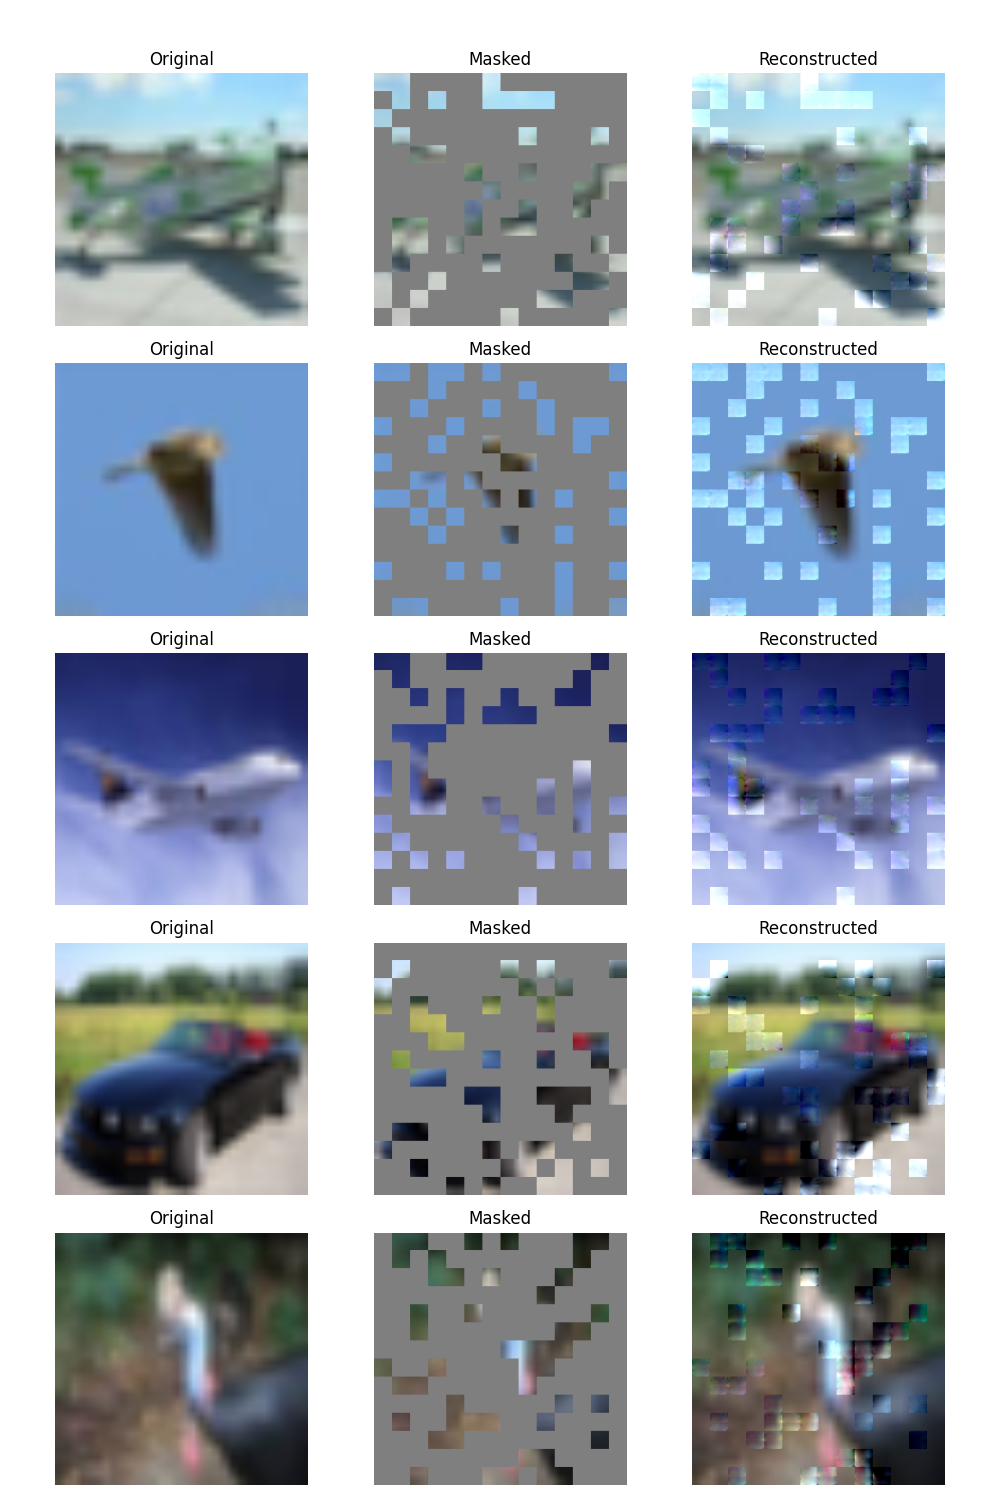

In [27]:
def patchify(img, patch_size):
    # img: (B, 3, H, W)
    B, C, H, W = img.shape
    assert H == W and H % patch_size == 0

    h = w = H // patch_size
    patches = img.reshape(B, C, h, patch_size, w, patch_size)
    patches = patches.permute(0, 2, 4, 3, 5, 1).reshape(B, h * w, patch_size * patch_size * C)
    return patches

def unpatchify(patches, patch_size, img_size):
    # patches: (B, N, patch_dim)
    B, N, patch_dim = patches.shape
    H = W = img_size
    h = w = H // patch_size
    assert N == h * w

    patches = patches.reshape(B, h, w, patch_size, patch_size, 3)
    patches = patches.permute(0, 5, 1, 3, 2, 4).reshape(B, 3, H, W)
    return patches

def visualize_and_save_reconstruction(mae_model, dataloader, save_path="mae_reconstruction.png", num_images=4):
    mae_model.eval()
    patch_size = mae_model.config.patch_size
    img_size = mae_model.config.image_size

    fig, axs = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    images_shown = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = mae_model(pixel_values=images, return_dict=True)
            recon_patches = outputs.logits  # shape: (B, N, patch_dim)
            mask = outputs.mask             # shape: (B, N)

            # Unnormalize for visualization
            unnorm_images = images * 0.5 + 0.5  # [0,1] range

            for i in range(min(num_images, images.size(0))):
                orig = unnorm_images[i].permute(1, 2, 0).cpu().numpy()

                # Convert mask to boolean tensor
                bool_mask = mask[i].to(torch.bool)

                # Masked image: original with masked patches removed (set to zero)
                img_patches = patchify(images[i].unsqueeze(0), patch_size)  # (1, N, dim)
                img_patches[0][bool_mask] = 0  # zero out masked patches
                masked_img = unpatchify(img_patches, patch_size, img_size)[0]
                masked_img = (masked_img * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()

                # Reconstructed image: use only reconstructed masked patches
                recon = recon_patches[i]
                target_patches = patchify(images[i].unsqueeze(0), patch_size)[0]
                # Inverse mask: True where original patches are not masked.
                inv_mask = ~bool_mask
                target_patches[inv_mask] = recon[inv_mask]  # fill in known patches from reconstructed ones
                recon_img = unpatchify(target_patches.unsqueeze(0), patch_size, img_size)[0]
                recon_img = (recon_img * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()

                axs[i, 0].imshow(orig)
                axs[i, 0].set_title("Original")
                axs[i, 1].imshow(masked_img)
                axs[i, 1].set_title("Masked")
                axs[i, 2].imshow(recon_img)
                axs[i, 2].set_title("Reconstructed")

                for j in range(3):
                    axs[i, j].axis('off')

                images_shown += 1
                if images_shown >= num_images:
                    break
            if images_shown >= num_images:
                break
    fig.suptitle("Seen_Images Reconstruction Visualization", fontsize=16, y=1.02)
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close()
    print(f"Saved reconstruction visualization to: {save_path}")

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

visualize_and_save_reconstruction(
    mae_model,
    train_loader,
    save_path="mae_finetune_outputs/seen_reconstruction_result.png",
    num_images=5
)

# Show the saved image inline (for Kaggle notebooks)
img = Image.open("mae_finetune_outputs/seen_reconstruction_result.png")
display(img)


In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

# Evaluate
model.eval()
y_true = []
y_pred = []
rec_errors = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        logits, rec_output, cls_token = model(images)
        rec_error = ((rec_output - cls_token) ** 2).mean(dim=1)

        for i in range(images.size(0)):
            # True label: all are unseen (labels in 5-9) → map to 1 (unseen)
            y_true.append(1)
            # Prediction: rec error > threshold = unseen (1), else seen (0)
            y_pred.append(int(rec_error[i].item() > anomaly_threshold))
            rec_errors.append(rec_error[i].item())

# Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, rec_errors)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Save metrics
metrics = {
    "f1_score": f1,
    "precision": precision,
    "recall": recall,
    "roc_auc": roc_auc
}
with open("mae_finetune_outputs/eval_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Seen", "Unseen"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Seen vs Unseen)")
plt.savefig("mae_finetune_outputs/confusion_matrix.png")
plt.close()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, rec_errors)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("mae_finetune_outputs/roc_curve.png")
plt.close()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [30]:
import torch
import json
from transformers import ViTMAEForPreTraining

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained MAE model
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)

# Load the classifier model (ensure this is consistent with what you used during training)
class ViTMAEClassifier(nn.Module):
    def __init__(self, mae_model, num_classes, freeze_encoder=False):
        super(ViTMAEClassifier, self).__init__()
        self.encoder = mae_model.base_model  
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        hidden_size = mae_model.config.hidden_size
        self.cls_head = nn.Linear(hidden_size, num_classes)
        self.rec_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        enc_out = self.encoder(x).last_hidden_state
        cls_token = enc_out[:, 0]
        logits = self.cls_head(cls_token)
        rec_output = self.rec_head(cls_token)
        return logits, rec_output, cls_token

# Define number of classes for the classifier
num_seen_classes = 5  # Assuming you trained on 5 seen classes

# Initialize the classifier
model = ViTMAEClassifier(mae_model, num_seen_classes, freeze_encoder=False).to(device)

# Load the trained weights
model.load_state_dict(torch.load("./mae_finetune_outputs/mae_classifier.pth"))

# Load the training log (optional)
with open("./mae_finetune_outputs/training_log.json", "r") as f:
    training_log = json.load(f)

# Check the training details
print(training_log)


/tmp/ipykernel_31/4272341869.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./mae_finetune_outputs/mae_classifier.pth"))


{'epochs': [{'epoch': 1, 'avg_class_loss': 0.4884764393082488, 'avg_rec_loss': 0.02248028846384906, 'train_acc': 81.904}, {'epoch': 2, 'avg_class_loss': 0.2764101188816964, 'avg_rec_loss': 0.008918965229691886, 'train_acc': 90.256}, {'epoch': 3, 'avg_class_loss': 0.22536530536441554, 'avg_rec_loss': 0.005720643615779143, 'train_acc': 92.04}, {'epoch': 4, 'avg_class_loss': 0.1958888720238959, 'avg_rec_loss': 0.003955411471507523, 'train_acc': 93.164}, {'epoch': 5, 'avg_class_loss': 0.1744395067710644, 'avg_rec_loss': 0.002912928804460858, 'train_acc': 93.712}]}


In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true = []
y_pred_prob = []  # Store probabilities for each class

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get logits and reconstructed output
        logits, _, _ = model(images)
        
        # Get probabilities using softmax
        probs = torch.softmax(logits, dim=1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred_prob.append(probs.cpu().numpy())

# Convert list of probabilities into numpy array for use in ROC curve
y_pred_prob = np.concatenate(y_pred_prob, axis=0)

# Multi-class ROC curve
n_classes = len(set(y_true))  # Number of unique classes in y_true
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Compute ROC curve and AUC for each class
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


ValueError: Expected array-like (array or non-string sequence), got False

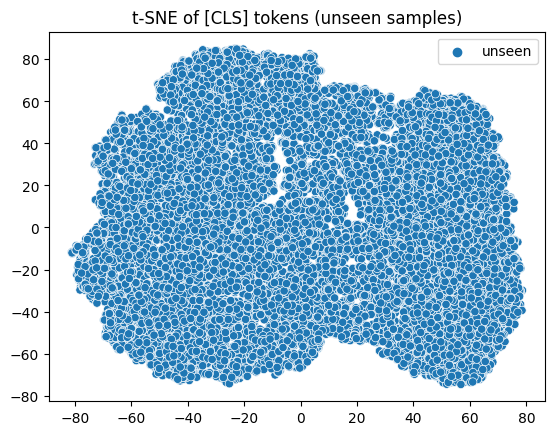

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns

# Get latent features and labels
latent_features = []
true_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        _, _, cls_token = model(images)
        latent_features.append(cls_token.cpu())
        true_labels.extend(["unseen"] * len(labels))  # since it's from unseen set

latent_features = torch.cat(latent_features, dim=0).numpy()
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(latent_features)

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=true_labels)
plt.title("t-SNE of [CLS] tokens (unseen samples)")
plt.show()


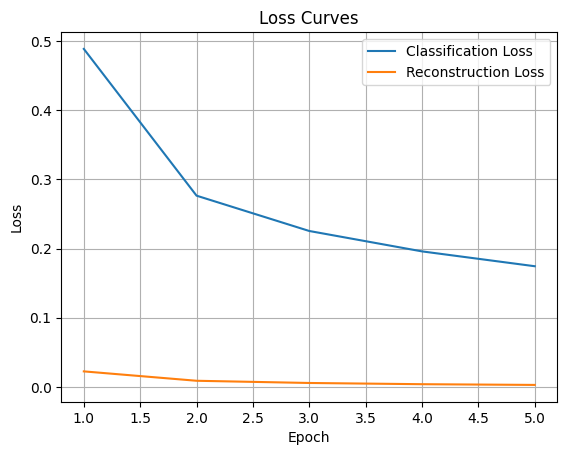

In [6]:
epochs = [e['epoch'] for e in training_log["epochs"]]
cls_losses = [e['avg_class_loss'] for e in training_log["epochs"]]
rec_losses = [e['avg_rec_loss'] for e in training_log["epochs"]]

plt.plot(epochs, cls_losses, label="Classification Loss")
plt.plot(epochs, rec_losses, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.grid(True)
plt.show()


In [8]:
plt.hist(seen_rec_errors.cpu().numpy(), bins=50, alpha=0.6, label="Seen")
plt.hist(unseen_rec_errors.cpu().numpy(), bins=50, alpha=0.6, label="Unseen")
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', label="Threshold")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


NameError: name 'seen_rec_errors' is not defined